In [2109]:
#!pip install -U scikit-learn==1.5.1
#!pip install numpy==2.1.0

#!pip uninstall -y numpy scikit-learn scipy
#!pip install numpy==1.24.3 scikit-learn==1.5.1 scipy==1.10.1


import sklearn
print(sklearn.__version__)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, mean_squared_error
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Lasso
!pip install catboost
import catboost as cb
import pickle

import matplotlib.pyplot as plt

1.5.2


# Lectura dataset

In [2110]:
archivo = "inmuebles_sin_CABA.csv"

In [2111]:
df_inmuebles = pd.read_csv(archivo)

<ipython-input-2111-4c33c5f48d76>:1: DtypeWarning: Columns (4,5,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df_inmuebles = pd.read_csv(archivo)


# ANALISIS EXPLORATORIO

## Elimino duplicados y columnas innecesarias

In [2112]:
df_inmuebles.drop_duplicates(inplace=True)
df_inmuebles = df_inmuebles.drop(['expensas', 'direccion','disposicion','orientacion','luminosidad','cancha_deportes','lavavajillas','estado_general','amoblado.1','internet','laundry', 'lavadero', 'lavarropas', 'secarropas','cocina_equipada', 'frigobar', 'microondas','ascensor','sala_de_juegos','solarium','apto_profesional','dependencia_servicio','dormitorio_en_suite','jardin','quincho','sum','sauna','lavadero','balcon','patio','terraza','parrilla','gimnasio','hidromasaje','uso_comercial','acceso_movilidad_reducida','servicio_de_limpieza','termotanque','amoblado'], axis=1)
df_inmuebles = df_inmuebles.dropna(subset=['precio'])

## Conversion de divisas (USD)

In [2113]:
valor_dolar = 1000

### Operaciones en dolares

#### Precio

In [2114]:
df_usd = df_inmuebles[df_inmuebles['precio'].str.contains('^USD', regex=True)]

In [2115]:
df_usd.loc[:, 'precio'] = df_usd['precio'].str.replace('USD', '').str.replace('.', '').astype(float)

### Operaciones en pesos

#### Precio

In [2116]:
df_ars = df_inmuebles[df_inmuebles['precio'].str.contains('^\$', regex=True)]

In [2117]:
df_dolarizado = df_ars.copy()
df_dolarizado['precio'] = df_dolarizado['precio'].str.replace('$', '').str.replace('.', '')

def es_float(valor):
    try:
        float(valor)
        return True
    except ValueError:
        return False


### Operaciones en otras divisas

In [2118]:
# Elimino aquellos registros que no se puedan castear. Por ejemplo si incluyen otro simbolo de otra moneda.
df_dolarizado = df_dolarizado[df_dolarizado['precio'].apply(es_float)]

df_dolarizado['precio'] = df_dolarizado['precio'].astype(float)

df_dolarizado['precio'] = df_dolarizado['precio'] / valor_dolar

### Concateno los datasets

In [2119]:
df_inmuebles = pd.concat([df_usd, df_dolarizado], axis=0)

## Casteo tipo de datos

In [2120]:
columnas_a_convertir = [
    'cantidad_de_toiletes', 'cantidad_de_cocheras', 'cantidad_de_dormitorios',
    'cantidad_de_banios', 'superficie_total', 'superficie_cubierta', 'cantidad_de_ambiente', 'precio'
]

for col in columnas_a_convertir:
    df_inmuebles[col] = pd.to_numeric(df_inmuebles[col], errors='coerce').fillna(0).astype('int64')

## Unifico baños y toiletes

In [2121]:
df_inmuebles['banios'] = df_inmuebles['cantidad_de_banios'] + (df_inmuebles['cantidad_de_toiletes'] / 2)

In [2122]:
df_inmuebles = df_inmuebles.drop(['cantidad_de_banios', 'cantidad_de_toiletes'], axis=1)

## Elimino filas con faltantes requeridos

In [2123]:
df_inmuebles = df_inmuebles.dropna(subset=['localidad'])

columnas_a_validar = ['precio','cantidad_de_ambiente']

for columna in columnas_a_validar:
  df_inmuebles = df_inmuebles[df_inmuebles[columna] > 0]

### Superficie total y superficie cubierta

In [2124]:
df_inmuebles.loc[(df_inmuebles['superficie_total'] == 0) & (df_inmuebles['superficie_cubierta'] > 0), 'superficie_total'] = df_inmuebles['superficie_cubierta']

df_inmuebles.loc[(df_inmuebles['superficie_cubierta'] == 0) & (df_inmuebles['superficie_total'] > 0), 'superficie_cubierta'] = df_inmuebles['superficie_total']

df_inmuebles = df_inmuebles[~((df_inmuebles['superficie_total'] == 0) & (df_inmuebles['superficie_cubierta'] == 0))]

## Remplazo los booleanos

In [2125]:
object_columns = df_inmuebles.select_dtypes(include=['object']).columns
df_inmuebles[object_columns] = df_inmuebles[object_columns].astype(str)

columnas = ['aire_acondicionado','alarma','caldera','calefacción','vigilancia','caja_fuerte','permite_mascotas','pileta']

for columna in columnas:
  df_inmuebles[columna] = (df_inmuebles[columna] == 'True').astype(int)

## Unifico seguridad

In [2126]:
df_inmuebles[['vigilancia', 'caja_fuerte', 'alarma']] = df_inmuebles[['vigilancia', 'caja_fuerte', 'alarma']].astype(float)
df_inmuebles = df_inmuebles.fillna(0)
df_inmuebles['seguridad'] = df_inmuebles['vigilancia']*0.75 + df_inmuebles['caja_fuerte']*0.1 + df_inmuebles['alarma']*0.5
df_inmuebles = df_inmuebles.drop(['vigilancia', 'caja_fuerte','alarma'], axis=1)

## Unifico calefaccion

In [2127]:
df_inmuebles[['aire_acondicionado', 'caldera', 'calefacción']] = df_inmuebles[['aire_acondicionado', 'caldera', 'calefacción']].astype(float)
df_inmuebles = df_inmuebles.fillna(0)
df_inmuebles['climatizacion'] = df_inmuebles['aire_acondicionado']*0.5 + df_inmuebles['caldera']*0.33 + df_inmuebles['calefacción']*0.33
df_inmuebles = df_inmuebles.drop(['aire_acondicionado', 'caldera', 'calefacción'], axis=1)

## Arreglo error cantidad de dormitorios

In [2128]:
df_inmuebles['cantidad_de_dormitorios'] = df_inmuebles['cantidad_de_dormitorios'].apply(lambda x: x + 1 if x == 0 else x)

## Modifico antiguedad

In [2129]:
df_inmuebles['antiguedad'] = df_inmuebles['antiguedad'].str.extract(r'(\d+)', expand=False)
df_inmuebles['antiguedad'] = pd.to_numeric(df_inmuebles['antiguedad']).fillna(0).astype(int)

## Agrego el precio por m2

In [2130]:
df_inmuebles['precio_m2'] = df_inmuebles['precio'] / df_inmuebles['superficie_total']

## Agrego el precio por m2 cubierto

In [2131]:
df_inmuebles['precio_m2_cubierto'] = df_inmuebles['precio'] / df_inmuebles['superficie_cubierta']

## Agrego precio m2 medio por localidad

In [2132]:
mean_encoded = df_inmuebles.groupby('localidad')['precio_m2'].mean()
df_inmuebles['precio_m2_medio'] = df_inmuebles['localidad'].map(mean_encoded)

## Agrego precio m2 cubierto medio por localidad

In [2133]:
mean_encoded = df_inmuebles.groupby('localidad')['precio_m2_cubierto'].mean()
df_inmuebles['precio_m2_cubierto_medio'] = df_inmuebles['localidad'].map(mean_encoded)

## Agrego precio medio localidad

In [2134]:
mean_encoded = df_inmuebles.groupby('localidad')['precio'].mean()
df_inmuebles['precio_medio'] = df_inmuebles['localidad'].map(mean_encoded)

## Agrego precio m2 medio por provincia

In [2135]:
mean_encoded = df_inmuebles.groupby('provincia')['precio_m2'].mean()
df_inmuebles['precio_m2_medio_prov'] = df_inmuebles['provincia'].map(mean_encoded)

## Agrego precio m2 cubierto medio por provincia

In [2136]:
mean_encoded = df_inmuebles.groupby('provincia')['precio_m2_cubierto'].mean()
df_inmuebles['precio_m2_cubierto_medio_prov'] = df_inmuebles['provincia'].map(mean_encoded)

## Agrego precio medio provincia

In [2137]:
mean_encoded = df_inmuebles.groupby('provincia')['precio'].mean()
df_inmuebles['precio_medio'] = df_inmuebles['provincia'].map(mean_encoded)

## Elimino los outliers

In [2138]:
def eliminar_outliers(grupo, columna):
      Q1 = grupo[columna].quantile(0.25)
      Q3 = grupo[columna].quantile(0.75)
      IQR = Q3 - Q1
      umbral_inferior = Q1 - 1.5 * IQR
      umbral_superior = Q3 + 1.5 * IQR
      return grupo[(grupo[columna] >= umbral_inferior) & (grupo[columna] <= umbral_superior)]


### Precio por localidad

In [2139]:
df_inmuebles = df_inmuebles.groupby('localidad').apply(eliminar_outliers, columna='precio').reset_index(drop=True)

<ipython-input-2139-03ccb0a4b3f2>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_inmuebles = df_inmuebles.groupby('localidad').apply(eliminar_outliers, columna='precio').reset_index(drop=True)


### Precio m2 por localidad

In [2140]:
df_inmuebles = df_inmuebles.groupby('localidad').apply(eliminar_outliers, columna='precio_m2').reset_index(drop=True)

<ipython-input-2140-13d66dfc0957>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_inmuebles = df_inmuebles.groupby('localidad').apply(eliminar_outliers, columna='precio_m2').reset_index(drop=True)


### Filtro diferencia entre precio m2 y precio m2 promedio por localidad

In [2141]:
def eliminar_filas_por_diferencia(df, col1, col2, umbral=0.60):
    diferencia_relativa = abs(df[col1] - df[col2]) / df[col2]

    df_filtrado = df[diferencia_relativa <= umbral]

    return df_filtrado

df_inmuebles = eliminar_filas_por_diferencia(df_inmuebles, 'precio_m2', 'precio_m2_medio')

## Elimino localidades poco comunes

In [2142]:
conteo_por_localidad = df_inmuebles.groupby('localidad').size()
localidades_comunes = conteo_por_localidad[conteo_por_localidad > 3]

df_inmuebles = df_inmuebles[df_inmuebles['localidad'].isin(localidades_comunes.index)]

localidad
Abasto, Rosario                  70
Acqua Río, Nordelta               5
Alberdi, Rosario                 13
Alto Alberdi, Córdoba            25
Alto Verde, Córdoba               4
                                 ..
Wilde, Avellaneda                52
Wyndham Condominios, Nordelta     9
Yerba Buena, Tucuman              6
Zelaya, Pilar                     6
Área Centro Este, Neuquén        13
Length: 287, dtype: int64


## Elimino localidad y provincia para correr el modelo

In [2145]:
df_inmuebles = df_inmuebles.drop(['localidad','provincia'], axis=1)

## OTRA COSA

In [2146]:
df_inmuebles.head()

,precio,superficie_total,superficie_cubierta,cantidad_de_ambiente,cantidad_de_dormitorios,antiguedad,cantidad_de_cocheras,permite_mascotas,pileta,banios,seguridad,climatizacion,precio_m2,precio_m2_cubierto,precio_m2_medio,precio_m2_cubierto_medio,precio_medio,precio_m2_medio_prov,precio_m2_cubierto_medio_prov
10,30,12,12,1,1,0,1,0,0,0.0,0.0,0.0,2.500000,2.500000,4.688729,5.0886,1930.604058,21.379866,24.108624
11,35,15,15,1,1,0,1,0,0,0.0,0.0,0.0,2.333333,2.333333,4.688729,5.0886,1930.604058,21.379866,24.108624
12,35,15,15,1,1,0,1,0,0,0.0,0.0,0.0,2.333333,2.333333,4.688729,5.0886,1930.604058,21.379866,24.108624
13,75,25,25,1,1,8,0,0,0,1.0,0.0,0.0,3.000000,3.000000,4.688729,5.0886,1930.604058,21.379866,24.108624
14,95,22,22,1,1,25,0,0,0,1.0,0.0,0.0,4.318182,4.318182,4.688729,5.0886,1930.604058,21.379866,24.108624


In [2147]:
numero_de_registros = df_inmuebles.shape[0]

print("El DataFrame tiene", numero_de_registros, "registros.")

El DataFrame tiene 3894 registros.


# Modelo

In [2150]:
# Separar las características y el objetivo
X = df_inmuebles.drop('precio', axis=1)
y = df_inmuebles['precio']

# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


model = cb.CatBoostRegressor(
    iterations=1500,
    learning_rate=0.1,
    depth=6,
    l2_leaf_reg=1,
    subsample=0.7,
    colsample_bylevel=0.7,
    bagging_temperature=2,
    random_strength=2,
    verbose=0
)

model.fit(X_train, y_train)

# Obtener la importancia de las características
feature_importances = model.get_feature_importance()

# Crear un DataFrame para las importancias
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

print(importance_df)

important_features = importance_df[importance_df['Importance'] > 0.5]['Feature']

print(important_features)

# Filtrar las características en X
X_filtered = df_inmuebles[important_features.tolist() + ['precio']]
X_train_filtered = X_filtered.drop('precio', axis=1)
y_filtered = X_filtered['precio']

# Dividir el dataset filtrado en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_train_filtered, y_filtered, test_size=0.2, random_state=42)

# Escalar las características filtradas
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

from joblib import dump

dump(scaler, 'scaler.joblib')

model_filtered = cb.CatBoostRegressor(
    iterations=1500,
    learning_rate=0.1,
    depth=4,
    l2_leaf_reg=1,
    subsample=0.8,
    colsample_bylevel=0.8,
    bagging_temperature=1,
    random_strength=1,
    verbose=0
)

model_filtered.fit(X_train, y_train)

# Hacer predicciones y evaluar el modelo
y_pred = model_filtered.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

model_filtered.save_model('modelo_filtrado.pkl')

                          Feature  Importance
0                superficie_total    0.815477
1             superficie_cubierta    3.658861
2            cantidad_de_ambiente    0.844028
3         cantidad_de_dormitorios    0.731229
4                      antiguedad    0.267640
5            cantidad_de_cocheras    0.006660
6                permite_mascotas    0.068773
7                          pileta    0.247925
8                          banios    1.675515
9                       seguridad    0.047058
10                  climatizacion    0.106456
11                      precio_m2    7.898119
12             precio_m2_cubierto    0.951054
13                precio_m2_medio   57.512122
14       precio_m2_cubierto_medio   24.581308
15                   precio_medio    0.051484
16           precio_m2_medio_prov    0.108766
17  precio_m2_cubierto_medio_prov    0.427524
0             superficie_total
1          superficie_cubierta
2         cantidad_de_ambiente
3      cantidad_de_dormitorios
8 

## Grafico de dispersion

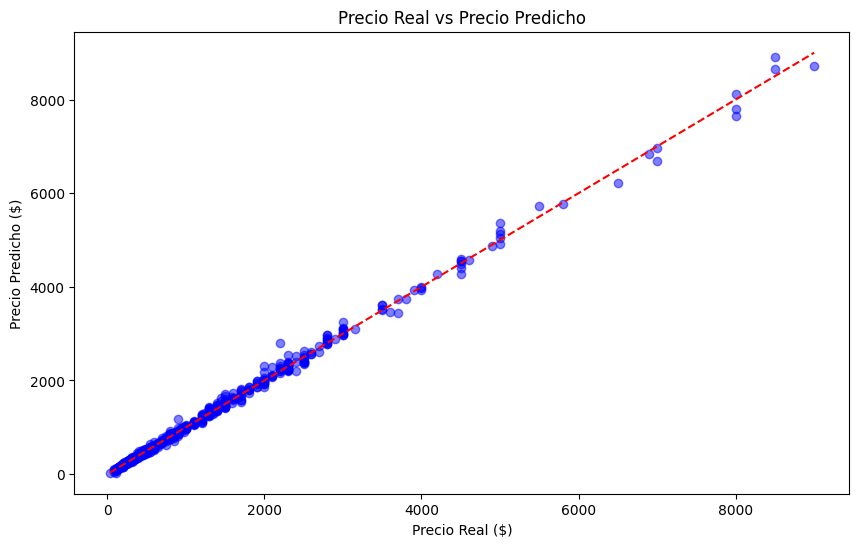

In [2151]:
# Gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Precio Real ($)')
plt.ylabel('Precio Predicho ($)')
plt.title('Precio Real vs Precio Predicho')
plt.show()

## Grafico de importancias

              Característica  Importancia
13           precio_m2_medio    57.512122
14  precio_m2_cubierto_medio    24.581308
11                 precio_m2     7.898119
1        superficie_cubierta     3.658861
8                     banios     1.675515
12        precio_m2_cubierto     0.951054
2       cantidad_de_ambiente     0.844028
0           superficie_total     0.815477
3    cantidad_de_dormitorios     0.731229


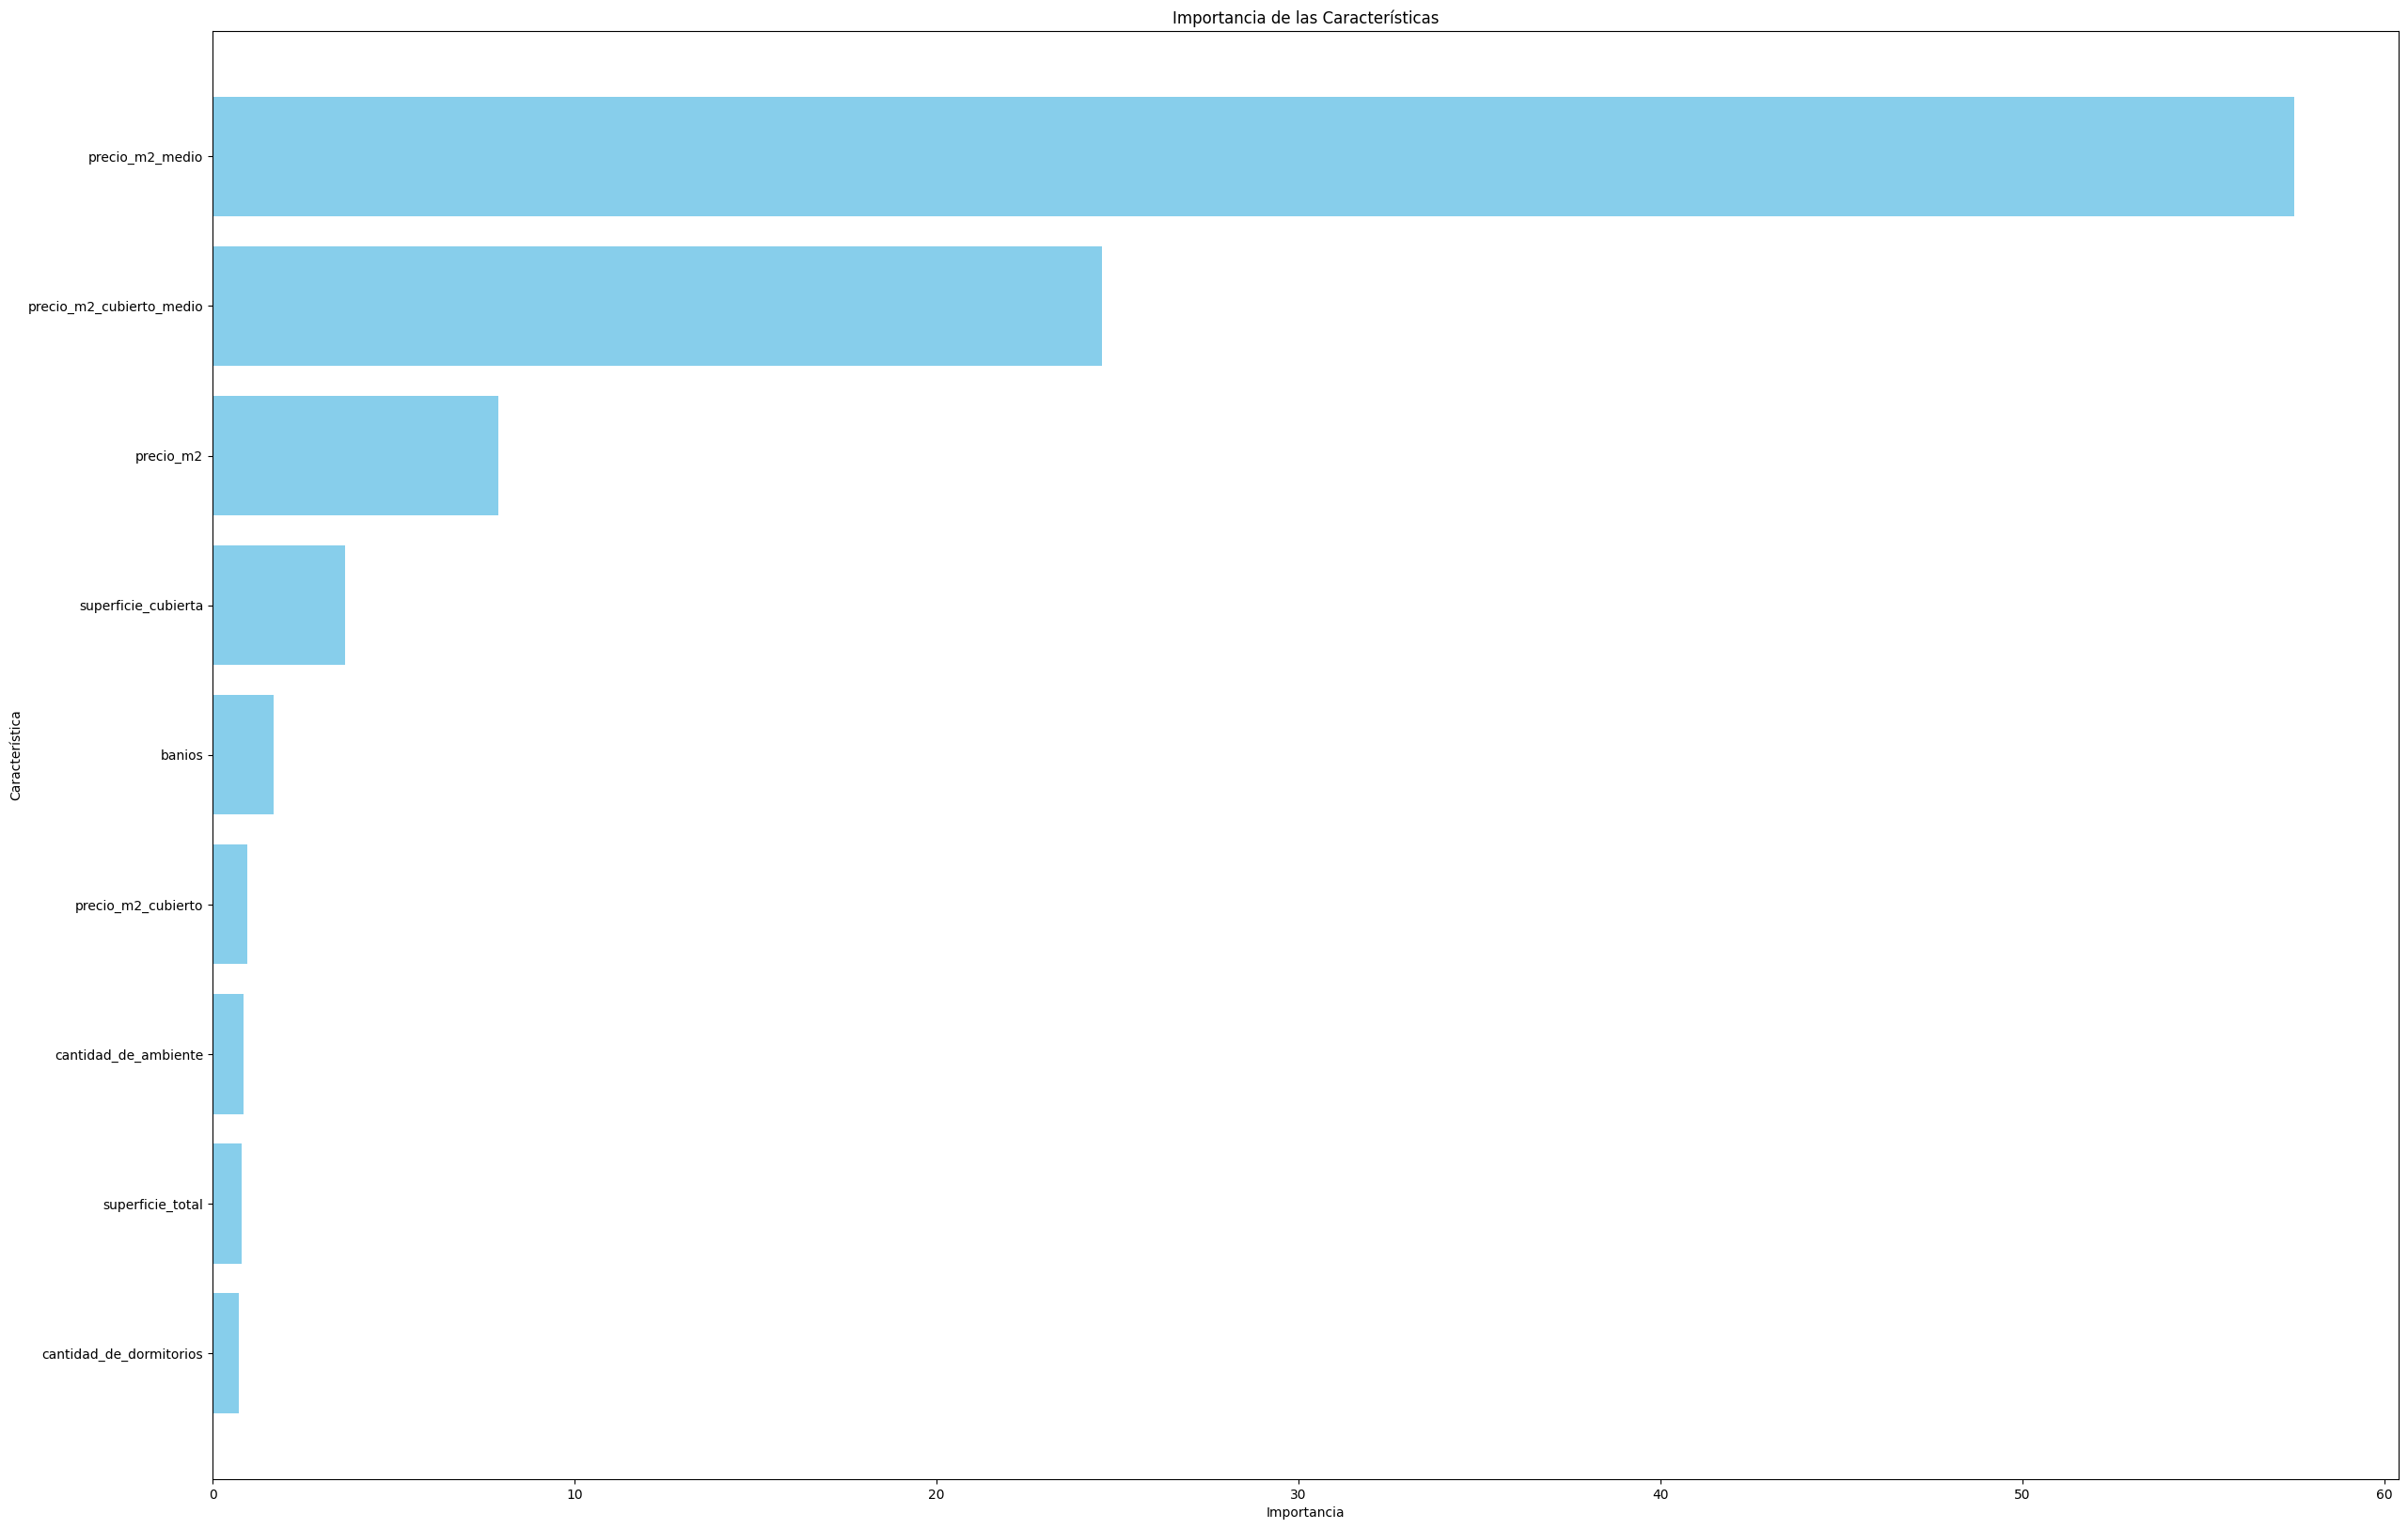

In [2152]:
# Obtener las importancias de las características
importancias = model.get_feature_importance()
columnas = X.columns

# Crear un DataFrame para facilitar la visualización
df_importancias = pd.DataFrame({'Característica': columnas, 'Importancia': importancias})

# Ordenar por importancia descendente
df_importancias = df_importancias.sort_values(by='Importancia', ascending=False)

df_importancias = df_importancias[df_importancias["Importancia"]>0.5]

# Mostrar las importancias
print(df_importancias)

# Graficar las importancias
plt.figure(figsize=(30, 20))
plt.barh(df_importancias['Característica'], df_importancias['Importancia'], color='skyblue')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.title('Importancia de las Características')
plt.gca().invert_yaxis()  # Invertir el eje y para que las más importantes estén arriba
plt.show()

In [2153]:
errores_absolutos = [abs(real - pred) for real, pred in zip(y_test, y_pred)]
errores_cuadraticos = [(real - pred)**2 for real, pred in zip(y_test, y_pred)]

df_comparacion = pd.DataFrame({
    'Precio Real ($)': y_test,
    'Precio Predicho ($)': y_pred,
    'Error Absoluto ($)': errores_absolutos,
    'Error Cuadrático ($²)': errores_cuadraticos
})

df_comparacion.loc['Promedio'] = df_comparacion.mean()

print("\nTabla de Comparación:")
print(df_comparacion)

df_comparacion.to_csv('df_comparacion.csv', index=False)



Tabla de Comparación:
          Precio Real ($)  Precio Predicho ($)  Error Absoluto ($)  \
8451           200.000000           194.011082            5.988918   
7675           320.000000           320.252040            0.252040   
10514          420.000000           414.823925            5.176075   
6601          4500.000000          4496.736649            3.263351   
1122          3000.000000          3075.621920           75.621920   
...                   ...                  ...                 ...   
7680           420.000000           393.126973           26.873027   
9894           300.000000           287.156979           12.843021   
10954          790.000000           828.672958           38.672958   
2708           290.000000           285.942929            4.057071   
Promedio      1047.181001          1049.967706           33.539768   

          Error Cuadrático ($²)  
8451                  35.867139  
7675                   0.063524  
10514                 26.791754  
